In [1]:
from Bio.PDB import *
import networkx as nx

# parser = PDBParser()
parser = MMCIFParser()
# structure = parser.get_structure("", "data/2kdk.pdb")
structure = parser.get_structure("", "data/clock_bmal1_modelled.cif")
models = structure.get_models()
protein = {}
for model in models:
    print("model")
    chains = model.get_chains()
    for chain in chains:
        chain_residues = []
        # print(chain.id)
        atoms = chain.get_atoms()
        # count = 0
        atoms_list = []
        for atom in atoms:
            if atom.name=="CA":
                atoms_list.append(atom)
                # count += 1
                ca_atom = atom
                ca_coord = atom.get_coord()
                # print(ca_atom, ca_coord)
                residue = atom.get_parent()
                # print(residue.get_resname())
                # if count==2:
                    # break
                chain_residues.append(atom)
        protein[chain.id] = chain_residues
        # print(atoms_list)
        # print(atoms_list[0]-atoms_list[1])
        # print(atoms_list[1]-atoms_list[0])

for chain in protein:
    print(len(protein[chain]))
    print(chain)
residueNames = []
for atom in protein["A"]:
    residue = atom.get_parent()
    residueNames.append(residue.get_resname())
for atom in protein["B"]:
    residue = atom.get_parent()
    residueNames.append(residue.get_resname())
print(len(residueNames))

distanceThreshold = 7.0
chainAEdges = []
chainA = protein['A']
for i in range(len(chainA)-1):
    for j in range(i+1, len(chainA)):
        distance = chainA[i]-chainA[j]
        if distance>0.0 and distance<=distanceThreshold:
            # print(i, j, distance)
            chainAEdges.append((i,j))
print("No. of edges in chain A graph:",len(chainAEdges))

nodeIdGap = len(protein['A'])
chainBEdges = []
chainB = protein['B']
for i in range(len(chainB)-1):
    for j in range(i+1, len(chainB)):
        distance = chainB[i]-chainB[j]
        if distance>0.0 and distance<=distanceThreshold:
            # print(i+nodeIdGap, j+nodeIdGap, distance)
            chainBEdges.append((i+nodeIdGap, j+nodeIdGap))
print("No. of edges in chain B graph:",len(chainBEdges))

chainAB = []
chainAB.extend(protein['A'])
chainAB.extend(protein['B'])
chainABEdges = []
for i in range(len(chainAB)-1):
    for j in range(i+1, len(chainAB)):
        distance = chainAB[i]-chainAB[j]
        if distance>0.0 and distance<=distanceThreshold:
            # print(i, j, distance)
            chainABEdges.append((i,j))
print("No. of edges in chain AB graph:",len(chainABEdges))
print(len(chainABEdges)-len(chainBEdges)-len(chainAEdges))
g = nx.Graph(chainABEdges)
for x in g.neighbors(10): print(x)
for x in g.neighbors(364): print(x)

model
354
A
374
B
728
No. of edges in chain A graph: 1257
No. of edges in chain B graph: 1301
No. of edges in chain AB graph: 2638
80
6
7
8
9
11
12
13
14
360
361
362
363
365
366
367
368


2638
2514
2602
160


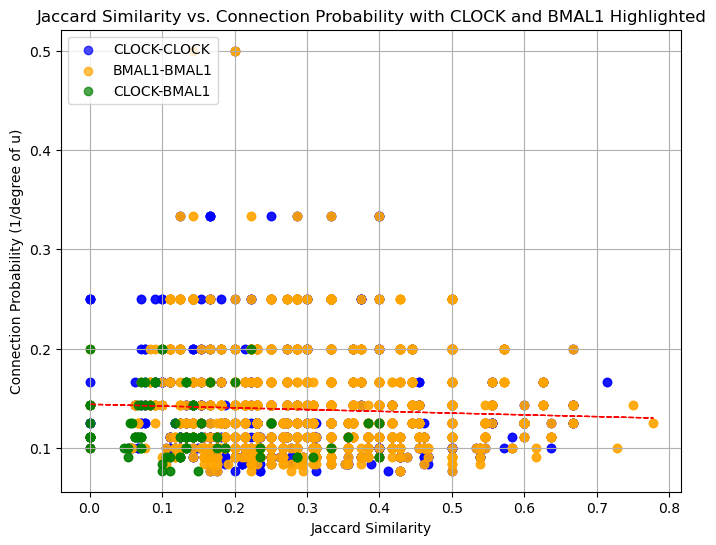

In [97]:
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

G = nx.Graph(chainABEdges)
print(len(chainABEdges))
# Calculate Jaccard similarity for all pairs of nodes
jaccard_coeffs = nx.jaccard_coefficient(G)
# print(jaccard_coeffs)
# Prepare lists to hold values for plotting
jaccard_values = []
connection_probabilities = []

def computeJC(nu, nv):
    intersection = set(nu).intersection(set(nv))
    union = set(nu).union(set(nv))
    return(len(intersection)/len(union))

clockIntra = []
bmal1Intra = []
clockBmal1Inter = []
# Calculate Jaccard similarity and connection probability for each edge
for u, v in chainABEdges:
    # Jaccard similarity value
    # jaccard_values.append(p)
    
    # Calculate connection probability based on degree of node u
    du = G.degree(u)
    dv = G.degree(v)
    nu = [x for x in G.neighbors(u)]
    nv = [x for x in G.neighbors(v)]
    # print(nu, nv)
    # break
    cu = 1 / du if du > 0 else 0
    cv = 1 / du if dv > 0 else 0
    jc = computeJC(nu, nv)
    # if not connection_probability:
    #     continue
    jaccard_values.append(jc)
    connection_probabilities.append(cu)
    jaccard_values.append(jc)
    connection_probabilities.append(cv)
    # connection_probabilities.append(connection_probability)
    if u<354 and v<354:
        clockIntra.append([jc, cu])
        clockIntra.append([jc, cv])
    elif u>=354 and v>=354:
        bmal1Intra.append([jc, cu])
        bmal1Intra.append([jc, cv])
    else:
        clockBmal1Inter.append([jc, cu])
        clockBmal1Inter.append([jc, cv])
print(len(clockIntra))
print(len(bmal1Intra))
print(len(clockBmal1Inter))
        
# Convert to numpy arrays for easier manipulation
jaccard_values = np.array(jaccard_values)
connection_probabilities = np.array(connection_probabilities)

# Create a scatter plot
plt.figure(figsize=(8, 6))

# Scatter for CLOCK and BMAL1 residues
# plt.scatter(jaccard_values, connection_probabilities, color='grey', alpha=0.5)

# Highlight CLOCK and BMAL1 residues
for x, y in clockIntra:
    plt.scatter(x, y, color='blue', label='CLOCK-CLOCK' if 'CLOCK-CLOCK' not in plt.gca().get_legend_handles_labels()[1] else "", alpha=0.7)
for x, y in bmal1Intra:
    plt.scatter(x, y, color='orange', label='BMAL1-BMAL1' if 'BMAL1-BMAL1' not in plt.gca().get_legend_handles_labels()[1] else "", alpha=0.7)
for x, y in clockBmal1Inter:
    plt.scatter(x, y, color='green', label='CLOCK-BMAL1' if 'CLOCK-BMAL1' not in plt.gca().get_legend_handles_labels()[1] else "", alpha=0.7)

# # Set axis labels and title
plt.xlabel('Jaccard Similarity')
plt.ylabel('Connection Probability (1/degree of u)')
plt.title('Jaccard Similarity vs. Connection Probability with CLOCK and BMAL1 Highlighted')

# Optionally add a line of best fit
m, b = np.polyfit(jaccard_values, connection_probabilities, 1)  # Linear fit
plt.plot(jaccard_values, m * jaccard_values + b, color='red', linestyle='--', linewidth=1)

plt.grid()
plt.legend(loc='upper left')
plt.show()

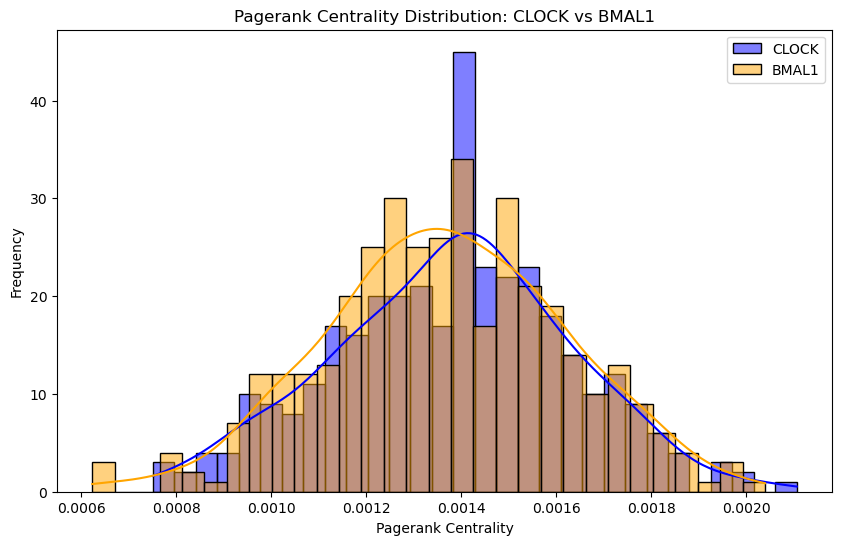

0 1
1


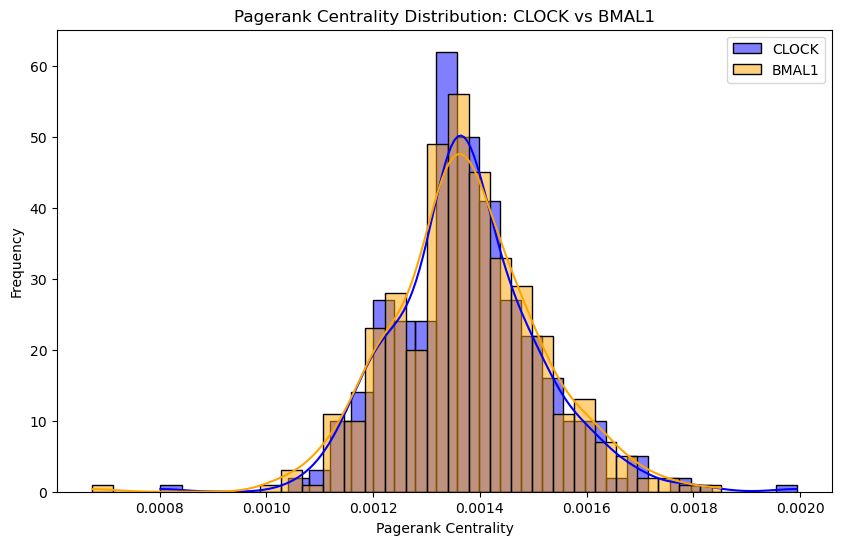

In [61]:
pagerank_centrality = nx.pagerank(G, max_iter=1000, tol=1e-6, weight='weight')

# Separate eigenvector centrality for CLOCK and BMAL1
clock_pagerank = {node: ec for node, ec in pagerank_centrality.items() if node<354}
bmal1_pagerank = {node: ec for node, ec in pagerank_centrality.items() if node>=354}

# Plot the eigenvector centrality for CLOCK and BMAL1
plt.figure(figsize=(10, 6))
sns.histplot(list(clock_pagerank.values()), color='blue', label='CLOCK', kde=True, bins=30)
sns.histplot(list(bmal1_pagerank.values()), color='orange', label='BMAL1', kde=True, bins=30)

plt.title('Pagerank Centrality Distribution: CLOCK vs BMAL1')
plt.xlabel('Pagerank Centrality')
plt.ylabel('Frequency')
plt.legend()
plt.show()

transMat = [[0.]*728 for _ in range(728)]
wG = nx.Graph(chainABEdges)
for u, v in chainABEdges:
    if (u<354 and v<354) or (u>=354 and v>=354):
        transMat[u][v] = .8
        transMat[v][u] = .8
    else:
        # print(u,v)
        # break
        transMat[u][v] = .2
        transMat[v][u] = .2
transMat = np.array(transMat)
rowSums = transMat.sum(axis=1)
rowSums = rowSums[:, np.newaxis]
transMatNorm = transMat / rowSums
for u, v in chainABEdges:
    wG[u][v]['weight'] = transMatNorm[u][v]
count = 0
for u, v in wG.edges():
    count += 1
    print(u,v)
    break
print(count)

pagerank_centrality = nx.pagerank(wG, max_iter=1000, tol=1e-6, weight='weight')

# Separate eigenvector centrality for CLOCK and BMAL1
clock_pagerank = {node: ec for node, ec in pagerank_centrality.items() if node<354}
bmal1_pagerank = {node: ec for node, ec in pagerank_centrality.items() if node>=354}

# Plot the eigenvector centrality for CLOCK and BMAL1
plt.figure(figsize=(10, 6))
sns.histplot(list(clock_pagerank.values()), color='blue', label='CLOCK', kde=True, bins=30)
sns.histplot(list(bmal1_pagerank.values()), color='orange', label='BMAL1', kde=True, bins=30)

plt.title('Pagerank Centrality Distribution: CLOCK vs BMAL1')
plt.xlabel('Pagerank Centrality')
plt.ylabel('Frequency')
plt.legend()
plt.show()

1.0


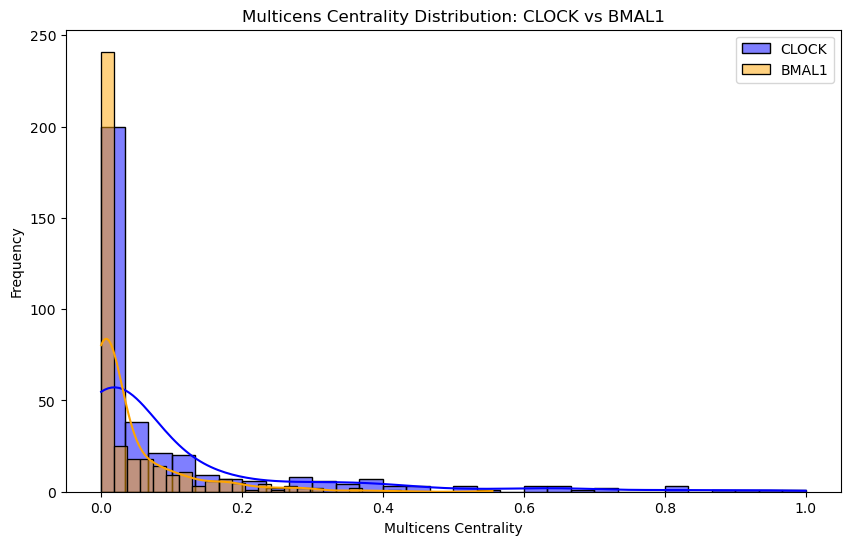

In [32]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def normalize_scores(scores):
    """ Normalize the scores to the range [0, 1]. """
    min_score = np.min(scores)
    max_score = np.max(scores)
    return (scores - min_score) / (max_score - min_score) if max_score > min_score else scores

def localCentrality(A, p, maxIterations=1000):
    # A = A/np.sum(A, axis=0)
    n = A.shape[0]
    l = np.ones(n) / n
    unitNormal = np.copy(l)
    angle = float(0)
    for _ in range(maxIterations):
        lNew = (p*(A.dot(l))) + ((1-p)*unitNormal)
        angleNew = angle_between(l, lNew)
        if (angleNew==angle) or (angleNew==0):
            break
        l, angle = lNew, angleNew
    return(l)

def globalCentrality(A, C, p, maxIterations=1000):
    l = normalize_scores(localCentrality(A, p))
    n = A.shape[0]
    g = np.ones(n) / n
    unitNormal = np.copy(g)
    angle = float(0)
    for _ in range(maxIterations):
        gNew = (p*((A+C).dot(g) + C.dot(l))) + ((1-p)*unitNormal)
        angleNew = angle_between(g, gNew)
        if (angleNew==angle) or (angleNew==0):
            break
        g, angle = gNew, angleNew
    g = normalize_scores(g)
    return(g,l)

# A = [[0, 1, 1], [1, 0, 0], [1, 0, 0]]
# l = localCentrality(np.array(A), 0.9)
# print(l)
# l = local_centrality(np.array(A), 1, 0.9)
# print(l)

A, C = np.zeros(shape=(728, 728)), np.zeros(shape=(728, 728))
for (u, v) in chainAEdges+chainBEdges:
    A[u, v] = 1.
    A[v, u] = 1.
for (u, v) in chainABEdges:
    if (u<354 and v>=354) or (v<354 and u>=354):
        C[u, v] = 1.
        C[v, u] = 1.

def column_normalize(matrix):
    """Normalize the given matrix by its columns."""
    # Calculate the sum of each column
    column_sums = np.sum(matrix, axis=0)
    # Avoid division by zero by replacing zeros with ones
    column_sums[column_sums == 0] = 1
    # Normalize each column
    normalized_matrix = matrix / column_sums
    return normalized_matrix

ANorm = column_normalize(A)
CNorm = column_normalize(C)
g, l = globalCentrality(A, C, 0.9)

multicens_centrality = g
print(max(multicens_centrality))
# multicens_centrality = [value * 1e5 for value in multicens_centrality]

# Separate eigenvector centrality for CLOCK and BMAL1
clock_eigenvector = {node: multicens_centrality[node] for node in range(len(multicens_centrality)) if node<354}
bmal1_eigenvector = {node: multicens_centrality[node] for node in range(len(multicens_centrality)) if node>=354}

# Plot the eigenvector centrality for CLOCK and BMAL1
plt.figure(figsize=(10, 6))
sns.histplot(list(clock_eigenvector.values()), color='blue', label='CLOCK', kde=True, bins=30)
sns.histplot(list(bmal1_eigenvector.values()), color='orange', label='BMAL1', kde=True, bins=30)
# plt.xscale('log')
# from matplotlib.ticker import FormatStrFormatter
# plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
plt.title('Multicens Centrality Distribution: CLOCK vs BMAL1')
plt.xlabel('Multicens Centrality')
plt.ylabel('Frequency')
plt.legend()
plt.show()

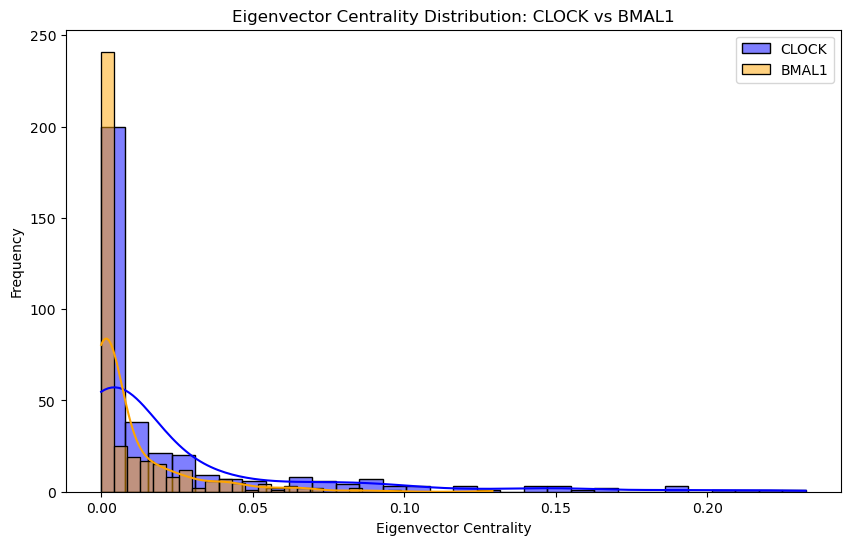

In [62]:
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-6, weight='weight')

# Separate eigenvector centrality for CLOCK and BMAL1
clock_eigenvector = {node: ec for node, ec in eigenvector_centrality.items() if node<354}
bmal1_eigenvector = {node: ec for node, ec in eigenvector_centrality.items() if node>=354}

# Plot the eigenvector centrality for CLOCK and BMAL1
plt.figure(figsize=(10, 6))
sns.histplot(list(clock_eigenvector.values()), color='blue', label='CLOCK', kde=True, bins=30)
sns.histplot(list(bmal1_eigenvector.values()), color='orange', label='BMAL1', kde=True, bins=30)

plt.title('Eigenvector Centrality Distribution: CLOCK vs BMAL1')
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Frequency')
plt.legend()
plt.show()

160


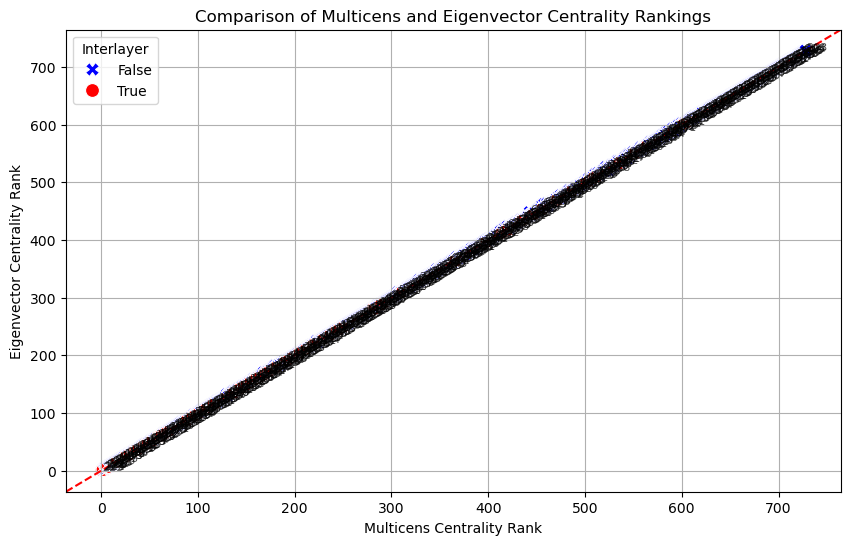

In [84]:
degree_centrality = g
nodes = [x for x in range(728)]

interNodes = []
for (u, v) in chainABEdges:
    if (u<354 and v>=354) or (v<354 and u>=354):
        interNodes.append(u)
        interNodes.append(v)
print(len(interNodes))

# Calculate Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-6, weight='weight')

# Create a DataFrame to store the centrality values and ranks
centrality_df = pd.DataFrame({
    'Residue': nodes,  # Assuming nodes are residue identifiers
    'Degree Centrality': list(degree_centrality),
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in nodes]
})

# Rank the centrality measures and store the ranks
centrality_df['Degree Rank'] = centrality_df['Degree Centrality'].rank(ascending=False, method='min')
centrality_df['Eigenvector Rank'] = centrality_df['Eigenvector Centrality'].rank(ascending=False, method='min')

# Create a column to indicate if the residue is part of interlayer edges
centrality_df['Interlayer'] = centrality_df['Residue'].isin(interNodes)

# Optional: Sort the DataFrame based on Degree Rank for better visualization
centrality_df.sort_values(by='Degree Rank', inplace=True)

# Plotting the rankings
plt.figure(figsize=(10, 6))
sns.scatterplot(data=centrality_df, 
                x='Degree Rank', 
                y='Eigenvector Rank', 
                hue='Interlayer', 
                palette={True: 'red', False: 'blue'},  # Red for interlayer, blue for others
                style='Interlayer',
                markers={True: 'o', False: 'X'},  # Circle for interlayer, X for others
                s=100)  # Adjust size for visibility

# Annotate points with residue names
for i in range(centrality_df.shape[0]):
    plt.text(centrality_df['Degree Rank'].iloc[i], centrality_df['Eigenvector Rank'].iloc[i],
             centrality_df['Residue'].iloc[i], fontsize=8, alpha=0.7)

plt.title('Comparison of Multicens and Eigenvector Centrality Rankings')
plt.xlabel('Multicens Centrality Rank')
plt.ylabel('Eigenvector Centrality Rank')
plt.xscale('linear')
plt.yscale('linear')
plt.grid(True)
plt.axline((0, 0), slope=1, color='red', linestyle='--')  # Diagonal line for reference
plt.show()

160


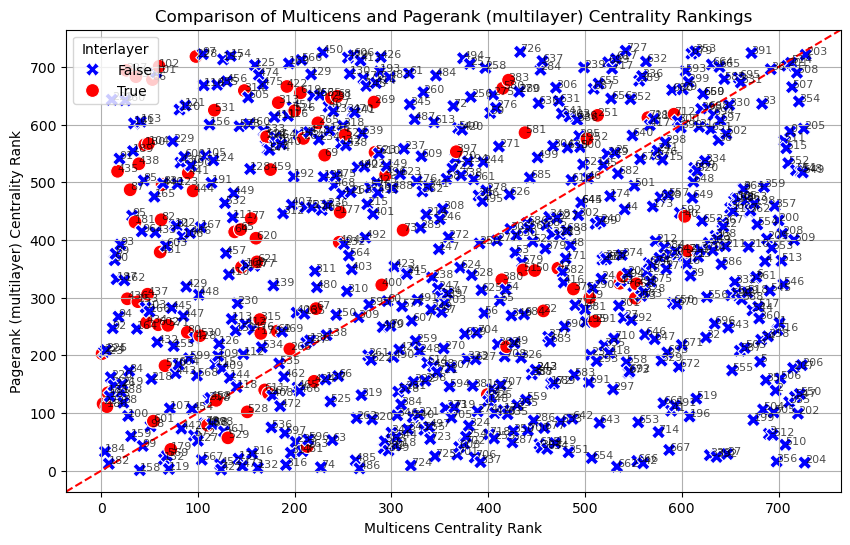

In [86]:
degree_centrality = g
nodes = [x for x in range(728)]

interNodes = []
for (u, v) in chainABEdges:
    if (u<354 and v>=354) or (v<354 and u>=354):
        interNodes.append(u)
        interNodes.append(v)
print(len(interNodes))

# Calculate Eigenvector Centrality
eigenvector_centrality = nx.pagerank(wG, max_iter=1000, tol=1e-6, weight='weight')

# Create a DataFrame to store the centrality values and ranks
centrality_df = pd.DataFrame({
    'Residue': nodes,  # Assuming nodes are residue identifiers
    'Degree Centrality': list(degree_centrality),
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in nodes]
})

# Rank the centrality measures and store the ranks
centrality_df['Degree Rank'] = centrality_df['Degree Centrality'].rank(ascending=False, method='min')
centrality_df['Eigenvector Rank'] = centrality_df['Eigenvector Centrality'].rank(ascending=False, method='min')

# Create a column to indicate if the residue is part of interlayer edges
centrality_df['Interlayer'] = centrality_df['Residue'].isin(interNodes)

# Optional: Sort the DataFrame based on Degree Rank for better visualization
centrality_df.sort_values(by='Degree Rank', inplace=True)

# Plotting the rankings
plt.figure(figsize=(10, 6))
sns.scatterplot(data=centrality_df, 
                x='Degree Rank', 
                y='Eigenvector Rank', 
                hue='Interlayer', 
                palette={True: 'red', False: 'blue'},  # Red for interlayer, blue for others
                style='Interlayer',
                markers={True: 'o', False: 'X'},  # Circle for interlayer, X for others
                s=100)  # Adjust size for visibility

# Annotate points with residue names
for i in range(centrality_df.shape[0]):
    plt.text(centrality_df['Degree Rank'].iloc[i], centrality_df['Eigenvector Rank'].iloc[i],
             centrality_df['Residue'].iloc[i], fontsize=8, alpha=0.7)

plt.title('Comparison of Multicens and Pagerank (multilayer) Centrality Rankings')
plt.xlabel('Multicens Centrality Rank')
plt.ylabel('Pagerank (multilayer) Centrality Rank')
plt.xscale('linear')
plt.yscale('linear')
plt.grid(True)
plt.axline((0, 0), slope=1, color='red', linestyle='--')  # Diagonal line for reference
plt.show()

160


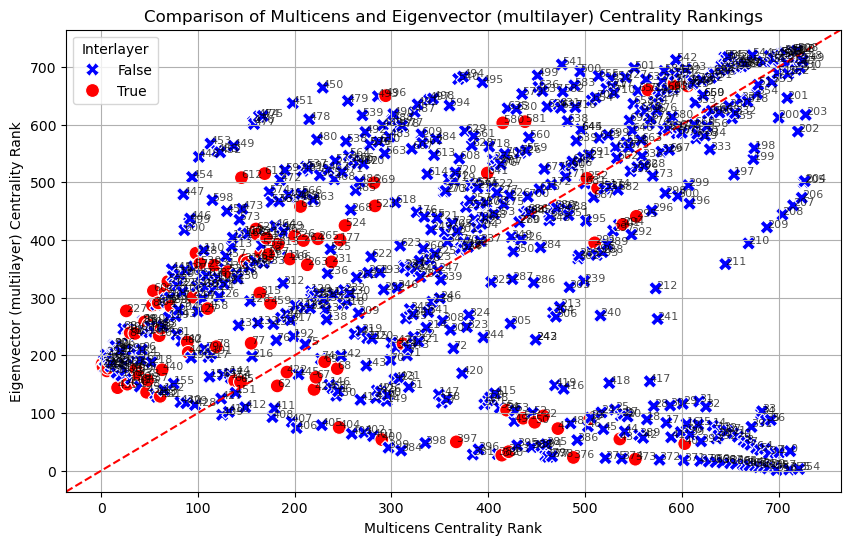

In [87]:
degree_centrality = g
nodes = [x for x in range(728)]

interNodes = []
for (u, v) in chainABEdges:
    if (u<354 and v>=354) or (v<354 and u>=354):
        interNodes.append(u)
        interNodes.append(v)
print(len(interNodes))

# Calculate Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(wG, max_iter=1000, tol=1e-6, weight='weight')

# Create a DataFrame to store the centrality values and ranks
centrality_df = pd.DataFrame({
    'Residue': nodes,  # Assuming nodes are residue identifiers
    'Degree Centrality': list(degree_centrality),
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in nodes]
})

# Rank the centrality measures and store the ranks
centrality_df['Degree Rank'] = centrality_df['Degree Centrality'].rank(ascending=False, method='min')
centrality_df['Eigenvector Rank'] = centrality_df['Eigenvector Centrality'].rank(ascending=False, method='min')

# Create a column to indicate if the residue is part of interlayer edges
centrality_df['Interlayer'] = centrality_df['Residue'].isin(interNodes)

# Optional: Sort the DataFrame based on Degree Rank for better visualization
centrality_df.sort_values(by='Degree Rank', inplace=True)

# Plotting the rankings
plt.figure(figsize=(10, 6))
sns.scatterplot(data=centrality_df, 
                x='Degree Rank', 
                y='Eigenvector Rank', 
                hue='Interlayer', 
                palette={True: 'red', False: 'blue'},  # Red for interlayer, blue for others
                style='Interlayer',
                markers={True: 'o', False: 'X'},  # Circle for interlayer, X for others
                s=100)  # Adjust size for visibility

# Annotate points with residue names
for i in range(centrality_df.shape[0]):
    plt.text(centrality_df['Degree Rank'].iloc[i], centrality_df['Eigenvector Rank'].iloc[i],
             centrality_df['Residue'].iloc[i], fontsize=8, alpha=0.7)

plt.title('Comparison of Multicens and Eigenvector (multilayer) Centrality Rankings')
plt.xlabel('Multicens Centrality Rank')
plt.ylabel('Eigenvector (multilayer) Centrality Rank')
plt.xscale('linear')
plt.yscale('linear')
plt.grid(True)
plt.axline((0, 0), slope=1, color='red', linestyle='--')  # Diagonal line for reference
plt.show()

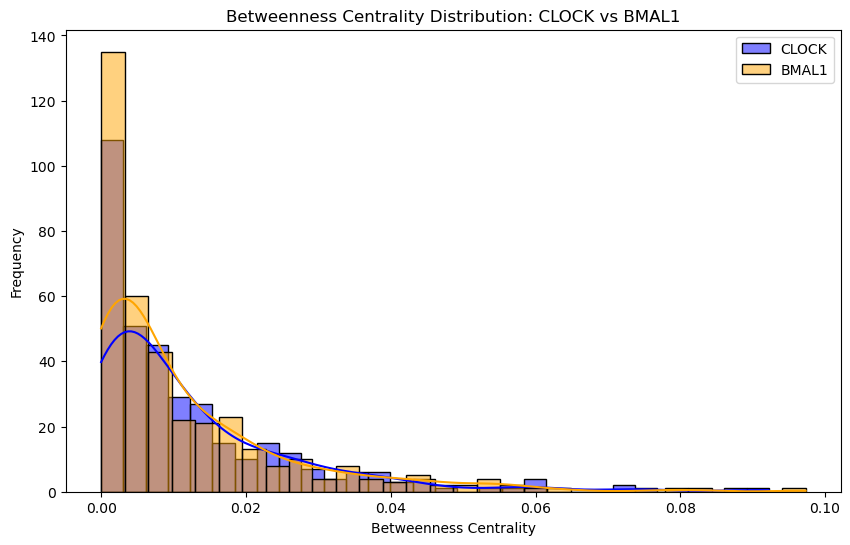

0 1
1


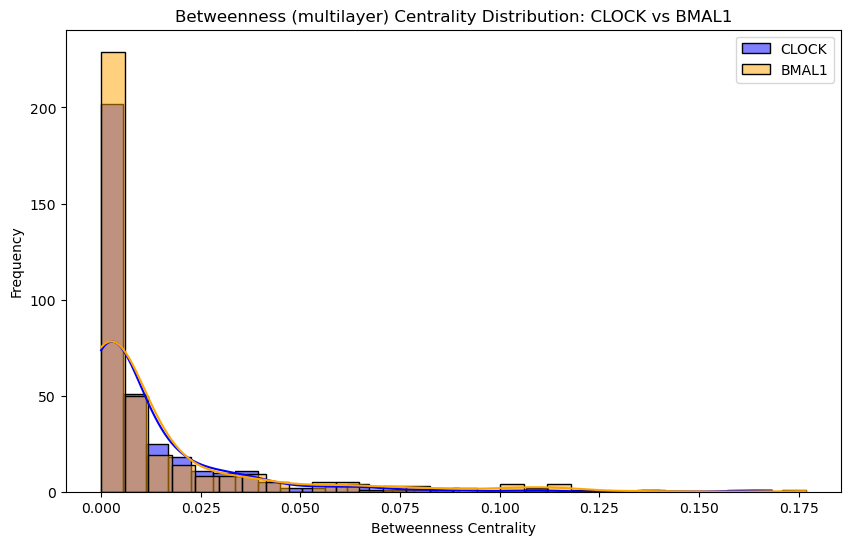

In [90]:
pagerank_centrality = nx.betweenness_centrality(G, weight='weight')

# Separate eigenvector centrality for CLOCK and BMAL1
clock_pagerank = {node: ec for node, ec in pagerank_centrality.items() if node<354}
bmal1_pagerank = {node: ec for node, ec in pagerank_centrality.items() if node>=354}

# Plot the eigenvector centrality for CLOCK and BMAL1
plt.figure(figsize=(10, 6))
sns.histplot(list(clock_pagerank.values()), color='blue', label='CLOCK', kde=True, bins=30)
sns.histplot(list(bmal1_pagerank.values()), color='orange', label='BMAL1', kde=True, bins=30)

plt.title('Betweenness Centrality Distribution: CLOCK vs BMAL1')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.legend()
plt.show()

transMat = [[0.]*728 for _ in range(728)]
wG = nx.Graph(chainABEdges)
for u, v in chainABEdges:
    if (u<354 and v<354) or (u>=354 and v>=354):
        transMat[u][v] = .2
        transMat[v][u] = .2
    else:
        # print(u,v)
        # break
        transMat[u][v] = .8
        transMat[v][u] = .8
transMat = np.array(transMat)
rowSums = transMat.sum(axis=1)
rowSums = rowSums[:, np.newaxis]
transMatNorm = transMat / rowSums
for u, v in chainABEdges:
    wG[u][v]['weight'] = transMatNorm[u][v]
count = 0
for u, v in wG.edges():
    count += 1
    print(u,v)
    break
print(count)

pagerank_centrality = nx.betweenness_centrality(wG, weight='weight')

# Separate eigenvector centrality for CLOCK and BMAL1
clock_pagerank = {node: ec for node, ec in pagerank_centrality.items() if node<354}
bmal1_pagerank = {node: ec for node, ec in pagerank_centrality.items() if node>=354}

# Plot the eigenvector centrality for CLOCK and BMAL1
plt.figure(figsize=(10, 6))
sns.histplot(list(clock_pagerank.values()), color='blue', label='CLOCK', kde=True, bins=30)
sns.histplot(list(bmal1_pagerank.values()), color='orange', label='BMAL1', kde=True, bins=30)

plt.title('Betweenness (multilayer) Centrality Distribution: CLOCK vs BMAL1')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.legend()
plt.show()

160
     Residue  Degree Centrality  Eigenvector Centrality  Degree Rank  \
0          0           0.000034                0.000000        712.0   
1          1           0.000075                0.000000        701.0   
2          2           0.000104                0.000000        697.0   
3          3           0.000139                0.002743        690.0   
4          4           0.000178                0.000000        686.0   
..       ...                ...                     ...          ...   
723      723           0.014088                0.040892        340.0   
724      724           0.016075                0.071892        320.0   
725      725           0.013665                0.042073        345.0   
726      726           0.006763                0.000003        433.0   
727      727           0.002988                0.000000        542.0   

     Eigenvector Rank  
0               576.0  
1               576.0  
2               576.0  
3               372.0  
4          

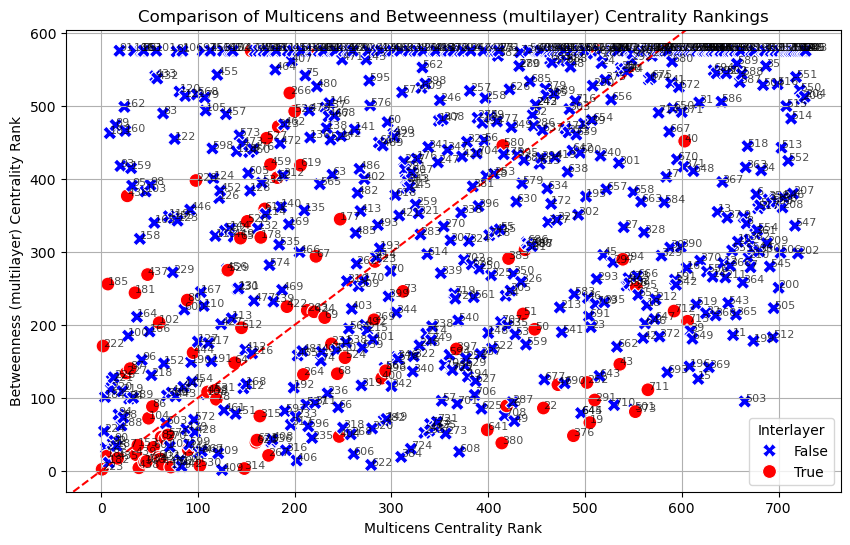

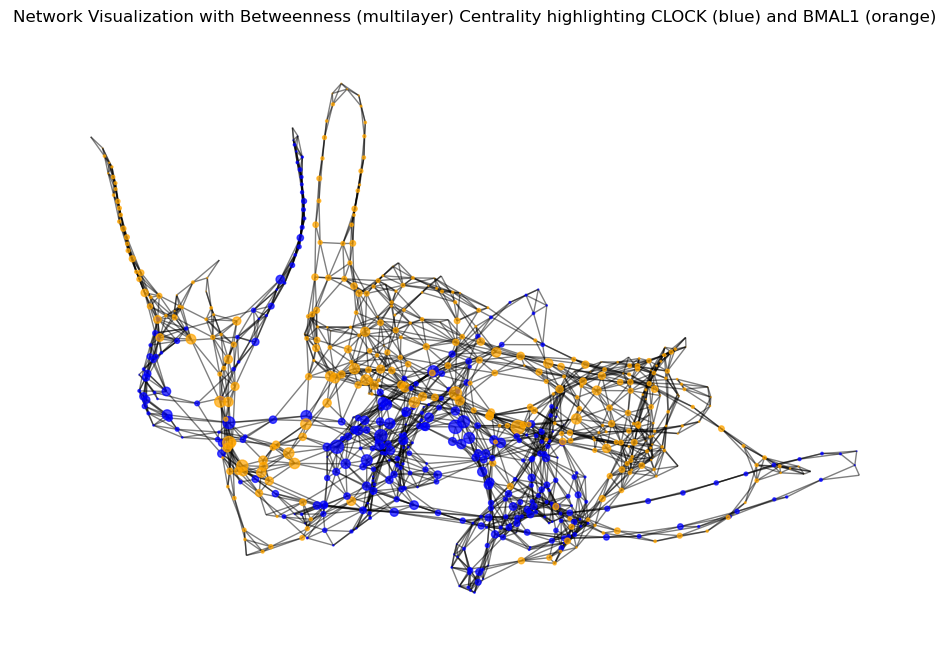

In [96]:
degree_centrality = g
nodes = [x for x in range(728)]

interNodes = []
for (u, v) in chainABEdges:
    if (u<354 and v>=354) or (v<354 and u>=354):
        interNodes.append(u)
        interNodes.append(v)
print(len(interNodes))

# Calculate Eigenvector Centrality
eigenvector_centrality = nx.betweenness_centrality(wG, weight='weight')

# Create a DataFrame to store the centrality values and ranks
centrality_df = pd.DataFrame({
    'Residue': nodes,  # Assuming nodes are residue identifiers
    'Degree Centrality': list(degree_centrality),
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in nodes]
})

# Rank the centrality measures and store the ranks
centrality_df['Degree Rank'] = centrality_df['Degree Centrality'].rank(ascending=False, method='min')
centrality_df['Eigenvector Rank'] = centrality_df['Eigenvector Centrality'].rank(ascending=False, method='min')
print(centrality_df)

# Create a column to indicate if the residue is part of interlayer edges
centrality_df['Interlayer'] = centrality_df['Residue'].isin(interNodes)

# Optional: Sort the DataFrame based on Degree Rank for better visualization
centrality_df.sort_values(by='Degree Rank', inplace=True)

# Plotting the rankings
plt.figure(figsize=(10, 6))
sns.scatterplot(data=centrality_df, 
                x='Degree Rank', 
                y='Eigenvector Rank', 
                hue='Interlayer', 
                palette={True: 'red', False: 'blue'},  # Red for interlayer, blue for others
                style='Interlayer',
                markers={True: 'o', False: 'X'},  # Circle for interlayer, X for others
                s=100)  # Adjust size for visibility

# Annotate points with residue names
for i in range(centrality_df.shape[0]):
    plt.text(centrality_df['Degree Rank'].iloc[i], centrality_df['Eigenvector Rank'].iloc[i],
             centrality_df['Residue'].iloc[i], fontsize=8, alpha=0.7)

plt.title('Comparison of Multicens and Betweenness (multilayer) Centrality Rankings')
plt.xlabel('Multicens Centrality Rank')
plt.ylabel('Betweenness (multilayer) Centrality Rank')
plt.xscale('linear')
plt.yscale('linear')
plt.grid(True)
plt.axline((0, 0), slope=1, color='red', linestyle='--')  # Diagonal line for reference
plt.show()

import matplotlib.pyplot as plt
import networkx as nx

# Create or load your graph G
# G = nx.Graph()

# Calculate betweenness centrality
betweenness = nx.betweenness_centrality(wG)

node_colors = ['blue' if node<354 else 'orange' for node in G.nodes()]
# Draw the network with node sizes based on betweenness centrality
node_sizes = [v * 1000 for v in betweenness.values()]  # Scale for visibility

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Positions for all nodes

# Draw nodes and edges
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)

# Add labels if needed
# nx.draw_networkx_labels(G, pos)

plt.title('Network Visualization with Betweenness (multilayer) Centrality highlighting CLOCK (blue) and BMAL1 (orange)')
plt.axis('off')
plt.show()

2638
2514
2602
160


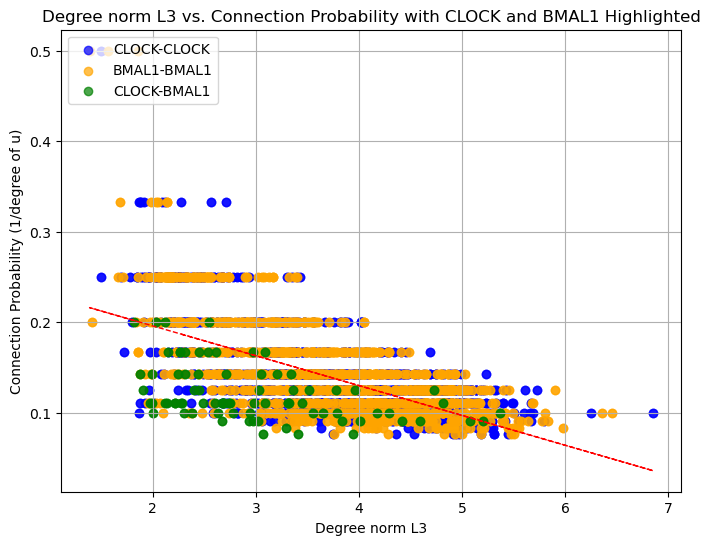

In [99]:
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

G = nx.Graph(chainABEdges)
print(len(chainABEdges))
# Calculate Jaccard similarity for all pairs of nodes
jaccard_coeffs = nx.jaccard_coefficient(G)
# print(jaccard_coeffs)
# Prepare lists to hold values for plotting
jaccard_values = []
connection_probabilities = []

def computeJC(nu, nv):
    intersection = set(nu).intersection(set(nv))
    union = set(nu).union(set(nv))
    return(len(intersection)/len(union))

def getDegNormL3(g, neighI, neighJ):
    pij = float(0)
    for u in neighI:
        uDegree = g.degree(u)
        for v in neighJ:
            if g.has_edge(u, v):
                vDegree = g.degree(v)
                pij += 1.0/(uDegree*vDegree)**(1/2)
    # print(degNormL3)
    return(pij)

clockIntra = []
bmal1Intra = []
clockBmal1Inter = []
# Calculate Jaccard similarity and connection probability for each edge
for u, v in chainABEdges:
    # Jaccard similarity value
    # jaccard_values.append(p)
    
    # Calculate connection probability based on degree of node u
    du = G.degree(u)
    dv = G.degree(v)
    nu = [x for x in G.neighbors(u)]
    nv = [x for x in G.neighbors(v)]
    # print(nu, nv)
    # break
    cu = 1 / du if du > 0 else 0
    cv = 1 / du if dv > 0 else 0
    jc = getDegNormL3(G, nu, nv)
    # if not connection_probability:
    #     continue
    jaccard_values.append(jc)
    connection_probabilities.append(cu)
    jaccard_values.append(jc)
    connection_probabilities.append(cv)
    # connection_probabilities.append(connection_probability)
    if u<354 and v<354:
        clockIntra.append([jc, cu])
        clockIntra.append([jc, cv])
    elif u>=354 and v>=354:
        bmal1Intra.append([jc, cu])
        bmal1Intra.append([jc, cv])
    else:
        clockBmal1Inter.append([jc, cu])
        clockBmal1Inter.append([jc, cv])
print(len(clockIntra))
print(len(bmal1Intra))
print(len(clockBmal1Inter))
        
# Convert to numpy arrays for easier manipulation
jaccard_values = np.array(jaccard_values)
connection_probabilities = np.array(connection_probabilities)

# Create a scatter plot
plt.figure(figsize=(8, 6))

# Scatter for CLOCK and BMAL1 residues
# plt.scatter(jaccard_values, connection_probabilities, color='grey', alpha=0.5)

# Highlight CLOCK and BMAL1 residues
for x, y in clockIntra:
    plt.scatter(x, y, color='blue', label='CLOCK-CLOCK' if 'CLOCK-CLOCK' not in plt.gca().get_legend_handles_labels()[1] else "", alpha=0.7)
for x, y in bmal1Intra:
    plt.scatter(x, y, color='orange', label='BMAL1-BMAL1' if 'BMAL1-BMAL1' not in plt.gca().get_legend_handles_labels()[1] else "", alpha=0.7)
for x, y in clockBmal1Inter:
    plt.scatter(x, y, color='green', label='CLOCK-BMAL1' if 'CLOCK-BMAL1' not in plt.gca().get_legend_handles_labels()[1] else "", alpha=0.7)

# # Set axis labels and title
plt.xlabel('Degree norm L3')
plt.ylabel('Connection Probability (1/degree of u)')
plt.title('Degree norm L3 vs. Connection Probability with CLOCK and BMAL1 Highlighted')

# Optionally add a line of best fit
m, b = np.polyfit(jaccard_values, connection_probabilities, 1)  # Linear fit
plt.plot(jaccard_values, m * jaccard_values + b, color='red', linestyle='--', linewidth=1)

plt.grid()
plt.legend(loc='upper left')
plt.show()